# Using Real Img

## Preview of Cropped Imgs

In [3]:
## define support functions
import math
import os
import cv2
import numpy as np
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
        
def get_file_path_from_folder(path):
    g = os.walk(path)
    tmp_lst = list()
    for _,_,file_list in g:
        for file_name in file_list:
            tmp_lst.append(os.path.join(path,file_name))
    return tmp_lst

def show_img_file(file_path):
    img = Image.open(file_path)
    plt.imshow(img, interpolation='none')
    plt.xticks([])
    plt.yticks([])
    plt.show() 

def show_imgs_in_folder(path):
    file_list = get_file_path_from_folder(path)
    img_lst = list()
    
    for i in range(len(file_list)):
        img = Image.open(file_list[i])
        img_lst.append(img)
        
    #fig = plt.figure()
    rect_size = math.ceil(math.sqrt(len(img_lst)))
    if math.floor(math.sqrt(len(img_lst)))*math.ceil(math.sqrt(len(img_lst))) >len (img_lst):
        rect_size_a = math.floor(math.sqrt(len(img_lst)))
        rect_size_b = math.ceil(math.sqrt(len(img_lst)))
    else:
        rect_size_a = rect_size_b = math.ceil(math.sqrt(len(img_lst)))
        
    for i in range(len(img_lst)):
        plt.subplot(rect_size_a,rect_size_b,i+1)
        plt.tight_layout()
        plt.imshow(img_lst[i], interpolation='none')
        plt.xticks([])
        plt.yticks([])
    plt.show()


path = "./img/"
show_imgs_in_folder(path)
#show_img_file(get_file_path_from_folder(path)[0])

FileNotFoundError: [Errno 2] No such file or directory: './img/1607.jpg'

## K-Means, Binarization and Elliptical Fit Code

# 白粉虱计数

In [21]:
## all code
import os
from flask import Flask, jsonify, render_template, request, url_for, send_from_directory
from werkzeug.utils import secure_filename
import math
import cv2
import numpy as np
from PIL import Image, ImageOps
from flask_cors import CORS
import requests
import base64


## sticky card crop function
def resizeImg(image, height=900):
    h, w = image.shape[:2]
    pro = height / h
    size = (int(w * pro), int(height))
    img = cv2.resize(image, size)
    return img

# canny edge detection
def getCanny(image):
    # 高斯模糊
    binary = cv2.GaussianBlur(image, (11, 11), 2, 2)
    # 边缘检测
    binary = cv2.Canny(binary, 60, 240, apertureSize=3)
    # 膨胀操作 尽量使边缘闭合
    kernel = np.ones((3, 3), np.uint8)
    binary = cv2.dilate(binary, kernel, iterations=1)
    return binary

# findMaxContour
def findMaxContour(image):
    # 寻找边缘
    contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    # 计算面积
    max_area = 0.0
    max_contour = []
    for contour in contours:
        currentArea = cv2.contourArea(contour)
        if currentArea > max_area:
            max_area = currentArea
            max_contour = contour
    return max_contour, max_area

# get hulk point of parallel
def getBoxPoint(contour):
    # 多边形拟合凸包
    hull = cv2.convexHull(contour)
    epsilon = 0.02 * cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(hull, epsilon, True)
    approx = approx.reshape((len(approx), 2))
    return approx

# get point value in oringal img
def adaPoint(box, pro):
    box_pro = box
    if pro != 1.0 :
        box_pro = box/pro
    box_pro = np.trunc(box_pro)
    return box_pro

# ordering point
def orderPoints(pts):
    rect = np.zeros((4, 2), dtype="float32")
    s = pts.sum(axis=1)# sum of point value(value_x + value_y)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    diff = np.diff(pts, axis=1)# diff between value_y and value_x
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    return rect

# calculate point distance
def pointDistance(a, b):
    return int(np.sqrt(np.sum(np.square(a - b))))

# PerspectiveTransform
def warpImage(image, box):
    w, h = pointDistance(box[0], box[1]), \
           pointDistance(box[1], box[2])
    dst_rect = np.array([[0, 0],
                         [w - 1, 0],
                         [w - 1, h - 1],
                         [0, h - 1]], dtype='float32')
    M = cv2.getPerspectiveTransform(box, dst_rect)
    warped = cv2.warpPerspective(image, M, (w, h))
    return warped

def sticky_card_crop(path):
    image = cv2.imread(path)
    ratio = 900 / image.shape[0]
    img = resizeImg(image)
    binary_img = getCanny(img)
    max_contour, _ = findMaxContour(binary_img)
    boxes = getBoxPoint(max_contour)
    boxes = adaPoint(boxes, ratio)
    boxes = orderPoints(boxes)
    warped = warpImage(image, boxes)
    return warped

## pading pic
def padding_pic(img):
    img_row_num = 3 - img.shape[0]%3
    img=cv2.copyMakeBorder(img, 0, img_row_num, 0, 0, cv2.BORDER_CONSTANT, value=0)
    return img

## K-Means, Binarization and Elliptical Fit Code
## K-means Code
def pest_count_by_kmeans_and_binarz(Img, num_clusters=2):
    #Img = cv2.imread(path, 1)
    Img = Img[:,:,0]
    # cv2.GaussianBlur
    blur = cv2.GaussianBlur(Img, (9, 9), 0)
    
    # binarization
    _, otsu = cv2.threshold(blur, 60, 255, cv2.THRESH_BINARY)
    
    # k-means
    data = otsu.reshape((-1,3))
    data = np.float32(data)
    # stop criteria: criteria flag(means one of them), iteration, epsilon
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    # cv2.kmeans input six parameter: source data, cluster number, preset labels, 
    # stop criteria, repeat times, initial center
    # cv2.kmeans return three value: retrurn value type, label of pixel, cluster center
    _,label,_=cv2.kmeans(data, num_clusters, None, criteria, 
                           num_clusters, cv2.KMEANS_RANDOM_CENTERS)
    color = np.uint8([[255, 0, 0],[128, 128, 128]])
    res = color[label.flatten()]
    result = res.reshape((Img.shape))
    return result

## Elliptical Fit Code
def Elliptical_Fit(kmeans_result, original_file):
    blur = cv2.GaussianBlur(kmeans_result, (9, 9), 0)
    _, otsu = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    # cv2.Canny input three value: source img, min value, max value
    binary = cv2.Canny(otsu, 80, 80 * 2)
    # cv2.findContours input three values: source img, detect model(external outline only), output value store type 
    contours,_ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    #src = original_file
    ellipse_area = list()
    for c in range(len(contours)):
        if contours[c].size/2 >4:
            # 椭圆拟合
            (cx, cy), (a, b), angle = cv2.fitEllipse(contours[c])
            # 绘制椭圆
            if (cx > 0) & (cy > 0):
                cv2.ellipse(original_file, (np.int32(cx), np.int32(cy)),
                           (np.int32(a/2), np.int32(b/2)), angle, 0, 360, (0, 0, 255), 1, 8)
                ellipse_area.append(round(math.pi*a*b/4,3))
    
    cv2.imwrite("Keamns_Elliptical_Fit_Output.jpg",original_file)
    #src = cv2.cvtColor(original_file, cv2.COLOR_BGR2RGB)
    plt.imshow(original_file),plt.xticks([]),plt.yticks([]),plt.show()
    return (original_file, ellipse_area)


## merge all code
def whitefly_counting(path):
    #croped_img = sticky_card_crop(path)
    croped_img = cv2.imread(path)
    img = padding_pic(croped_img)
    kmeans_result = pest_count_by_kmeans_and_binarz(img)
    Elliptical_Fit_result, ellipse_area = Elliptical_Fit(kmeans_result, croped_img)
    return Elliptical_Fit_result, ellipse_area

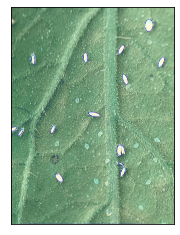

393

In [24]:
Elliptical_Fit_result, ellipse_area = whitefly_counting("./1.jpg")
len(ellipse_area)

# 粉虱计数

In [44]:
## K-Means, Binarization and Elliptical Fit Code
## K-means Code
def pest_count_by_kmeans_and_binarz(path, num_clusters=2):
    Img = cv2.imread(path, 1)
    #Img = cv2.cvtColor(Img, cv2.COLOR_BGR2LAB)
    #Img[:,:,0] = -100
    #Img = cv2.cvtColor(Img, cv2.COLOR_LAB2BGR)
    
    Img = Img[:,:,0]
#    Img[:,:,1] = 0
    Img = cv2.cvtColor(Img, cv2.COLOR_BGR2RGB)
#    plt.imshow(Img),plt.xticks([]), plt.yticks([]),plt.show()
    
    # cv2.GaussianBlur
    blur = cv2.GaussianBlur(Img, (3, 3), 0)
    
    # binarization
    _, otsu = cv2.threshold(blur, 200, 255, cv2.THRESH_BINARY)
    
    # k-means
    data = otsu.reshape((-1,3))
    data = np.float32(data)
    # stop criteria: criteria flag(means one of them), iteration, epsilon
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    # cv2.kmeans input six parameter: source data, cluster number, preset labels, 
    # stop criteria, repeat times, initial center
    # cv2.kmeans return three value: retrurn value type, label of pixel, cluster center
    _,label,center=cv2.kmeans(data, num_clusters, None, criteria, 
                           num_clusters, cv2.KMEANS_RANDOM_CENTERS)
    color = np.uint8([[255, 0, 0],[128, 128, 128]])
    res = color[label.flatten()]
    result = res.reshape((Img.shape))
    plt.imshow(result,'gray'),plt.xticks([]), plt.yticks([]),plt.show()
    return result

## Elliptical Fit Code
def Elliptical_Fit(kmeans_result, original_file_path):
    blur = cv2.GaussianBlur(kmeans_result, (3, 3), 0)
    #ret, otsu = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    ret, otsu = cv2.threshold(blur, 60, 255, cv2.THRESH_BINARY)
    # cv2.Canny input three value: source img, min value, max value
    binary = cv2.Canny(otsu, 80, 80 * 2)
    # cv2.findContours input three values: source img, detect model(external outline only), output value store type 
    contours,_ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    src = cv2.imread(original_file_path)
    ellipse_area = list()
    for c in range(len(contours)):
        if contours[c].size/2 >4:
            # 椭圆拟合
            (cx, cy), (a, b), angle = cv2.fitEllipse(contours[c])
            tmp_area = math.pi*a*b/4
            # 绘制椭圆
            if (cx > 0) & (cy > 0) :
                cv2.ellipse(src, (np.int32(cx), np.int32(cy)),
                           (np.int32(a/2), np.int32(b/2)), angle, 0, 360, (0, 0, 255), 1, 8)
                ellipse_area.append(round(math.pi*a*b/4,3))
    
    cv2.imwrite("Keamns_Elliptical_Fit_Output.jpg",src)
    src = cv2.cvtColor(src, cv2.COLOR_BGR2RGB)
    plt.imshow(src),plt.xticks([]),plt.yticks([]),plt.show()
    return (src, ellipse_area)

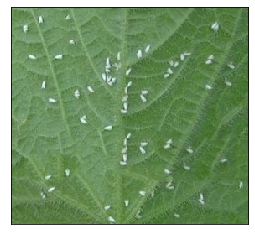

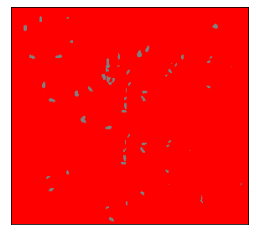

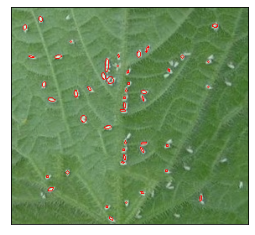

47

In [45]:
pic_num = 2
path = "./img/"
file_path = get_file_path_from_folder(path)[pic_num]
#file_path = "C:/Users/LC/Desktop/3.jpg."
file_path = "555.jpg"
show_img_file(file_path)
kmeans_result = pest_count_by_kmeans_and_binarz(file_path)
Elliptical_Fit_result, ellipse_area = Elliptical_Fit(kmeans_result, file_path)
len(ellipse_area)

# 蚜虫计数

In [202]:
## K-Means, Binarization and Elliptical Fit Code
## K-means Code
def pest_count_by_kmeans_and_binarz(path, num_clusters=2):
    Img = cv2.imread(path, 1)
    #Img = cv2.cvtColor(Img, cv2.COLOR_BGR2LAB)
    #Img[:,:,0] = -100
    #Img = cv2.cvtColor(Img, cv2.COLOR_LAB2BGR)
    
    Img = Img[:,:,2]
#    Img[:,:,1] = 0
#    Img = cv2.cvtColor(Img, cv2.COLOR_BGR2RGB)
 #   plt.imshow(Img,'gray'),plt.xticks([]), plt.yticks([]),plt.show()
#    plt.imshow(Img),plt.xticks([]), plt.yticks([]),plt.show()
    
    # cv2.GaussianBlur
    blur = cv2.GaussianBlur(Img, (13, 13), 0)
    
    # binarization
    _, otsu = cv2.threshold(blur, 200, 255, cv2.THRESH_BINARY)
    
    # k-means
    data = otsu.reshape((-1,3))
    data = np.float32(data)
    # stop criteria: criteria flag(means one of them), iteration, epsilon
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    # cv2.kmeans input six parameter: source data, cluster number, preset labels, 
    # stop criteria, repeat times, initial center
    # cv2.kmeans return three value: retrurn value type, label of pixel, cluster center
    _,label,center=cv2.kmeans(data, num_clusters, None, criteria, 
                           num_clusters, cv2.KMEANS_RANDOM_CENTERS)
    color = np.uint8([[255, 0, 0],[128, 128, 128]])
    res = color[label.flatten()]
    result = res.reshape((Img.shape))
  #  plt.imshow(result,'gray'),plt.xticks([]), plt.yticks([]),plt.show()
    return result

## Elliptical Fit Code
def Elliptical_Fit(kmeans_result, original_file_path):
    blur = cv2.GaussianBlur(kmeans_result, (13, 13), 0)
    #ret, otsu = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    ret, otsu = cv2.threshold(blur, 100, 255, cv2.THRESH_BINARY)
    # cv2.Canny input three value: source img, min value, max value
    binary = cv2.Canny(otsu, 80, 80 * 2)
    # cv2.findContours input three values: source img, detect model(external outline only), output value store type 
    contours,_ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    src = cv2.imread(original_file_path)
    ellipse_area = list()
    for c in range(len(contours)):
        if contours[c].size/2 >4:
            # 椭圆拟合
            (cx, cy), (a, b), angle = cv2.fitEllipse(contours[c])
            x,y,w,h= cv2.boundingRect(contours[c])
            cropped_contour= src[y:y+h, x:x+w]
            cropped_contour = cropped_contour[:,:,1]
            m_value = np.mean(cropped_contour)
            tmp_area = math.pi*a*b/4
            # 绘制椭圆
            if (cx > 0) & (cy > 0) :
                if (tmp_area > 800) & (m_value > 210):
                    cv2.ellipse(src, (np.int32(cx), np.int32(cy)),
                           (np.int32(a/2), np.int32(b/2)), angle, 0, 360, (0, 0, 255), 2, 8)
                    ellipse_area.append(round(math.pi*a*b/4,3))
                elif (m_value < 210) & (m_value > 10) & (tmp_area > 100):
                    cv2.ellipse(src, (np.int32(cx), np.int32(cy)),
                           (np.int32(a/2), np.int32(b/2)), angle, 0, 360, (255, 0, 0), 2, 8)
                    ellipse_area.append(round(math.pi*a*b/4,3))
                else :
                    continue
    
    cv2.imwrite("Keamns_Elliptical_Fit_Output.jpg",src)
    src = cv2.cvtColor(src, cv2.COLOR_BGR2RGB)
    plt.imshow(src),plt.xticks([]),plt.yticks([]),plt.show()
    return (src, ellipse_area)

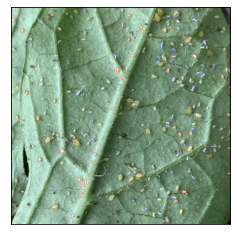

111

In [203]:
file_path = "C:/Users/LC/Desktop/5.png"
#show_img_file(file_path)
kmeans_result = pest_count_by_kmeans_and_binarz(file_path)
Elliptical_Fit_result, ellipse_area = Elliptical_Fit(kmeans_result, file_path)
len(ellipse_area)

 # Image Extract

In [157]:
## sticky card crop function
def resizeImg(image, height=900):
    h, w = image.shape[:2]
    pro = height / h
    size = (int(w * pro), int(height))
    img = cv2.resize(image, size)
    return img

# canny edge detection
def getCanny(image):
    # 高斯模糊
    binary = cv2.GaussianBlur(image, (11, 11), 2, 2)
    # 边缘检测
    binary = cv2.Canny(binary, 60, 240, apertureSize=3)
    # 膨胀操作，尽量使边缘闭合
    kernel = np.ones((3, 3), np.uint8)
    binary = cv2.dilate(binary, kernel, iterations=1)
    return binary

# findMaxContour
def findMaxContour(image):
    # 寻找边缘
    contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    # 计算面积
    max_area = 0.0
    max_contour = []
    for contour in contours:
        currentArea = cv2.contourArea(contour)
        if currentArea > max_area:
            max_area = currentArea
            max_contour = contour
    return max_contour, max_area

# get hulk point of parallel
def getBoxPoint(contour):
    # 多边形拟合凸包
    hull = cv2.convexHull(contour)
    epsilon = 0.02 * cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(hull, epsilon, True)
    approx = approx.reshape((len(approx), 2))
    return approx

# get point value in oringal img
def adaPoint(box, pro):
    box_pro = box
    if pro != 1.0:
        box_pro = box/pro
    box_pro = np.trunc(box_pro)
    return box_pro

# ordering point
def orderPoints(pts):
    rect = np.zeros((4, 2), dtype="float32")
    s = pts.sum(axis=1)# sum of point value(value_x + value_y)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    diff = np.diff(pts, axis=1)# diff between value_y and value_x
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    return rect

# calculate point distance
def pointDistance(a, b):
    return int(np.sqrt(np.sum(np.square(a - b))))

# 透PerspectiveTransform
def warpImage(image, box):
    w, h = pointDistance(box[0], box[1]), \
           pointDistance(box[1], box[2])
    dst_rect = np.array([[0, 0],
                         [w - 1, 0],
                         [w - 1, h - 1],
                         [0, h - 1]], dtype='float32')
    M = cv2.getPerspectiveTransform(box, dst_rect)
    warped = cv2.warpPerspective(image, M, (w, h))
    return warped

def sticky_card_crop(path):
    image = cv2.imread(path)
    ratio = 900 / image.shape[0]
    img = resizeImg(image)
    binary_img = getCanny(img)
    max_contour, max_area = findMaxContour(binary_img)
    boxes = getBoxPoint(max_contour)
    boxes = adaPoint(boxes, ratio)
    boxes = orderPoints(boxes)
    warped = warpImage(image, boxes)
    Img = cv2.cvtColor(warped, cv.COLOR_BGR2RGB)
    plt.imshow(Img),plt.xticks([]),plt.yticks([])
    return warped

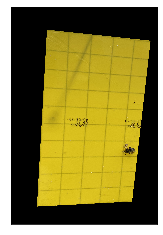

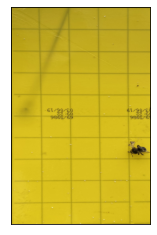

In [156]:
path = './org/'
i = 6
path = get_file_path_from_folder(path)[i]
show_img_file(path)
croped_img = sticky_card_crop(path)

# Padding Pic

In [159]:
## pic padding function
def padding_pic(path):
    img = cv2.imread(path)
    img_row_num = 3 - img.shape[0]%3
    img=cv2.copyMakeBorder(img, 0, img_row_num, 0, 0, cv2.BORDER_CONSTANT, value=0)
    return img

In [160]:
path = './crop/1.jpg'
tmp = padding_pic(path)
tmp.shape

(2922, 1528, 3)

# Merge Code

In [8]:
## define support functions
import math
import os
import cv2
import numpy as np
from PIL import Image, ImageOps

In [9]:
## sticky card crop function
def resizeImg(image, height=900):
    h, w = image.shape[:2]
    pro = height / h
    size = (int(w * pro), int(height))
    img = cv2.resize(image, size)
    return img

# canny edge detection
def getCanny(image):
    # 高斯模糊
    binary = cv2.GaussianBlur(image, (11, 11), 2, 2)
    # 边缘检测
    binary = cv2.Canny(binary, 60, 240, apertureSize=3)
    # 膨胀操作，尽量使边缘闭合
    kernel = np.ones((3, 3), np.uint8)
    binary = cv2.dilate(binary, kernel, iterations=1)
    return binary

# findMaxContour
def findMaxContour(image):
    # 寻找边缘
    contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    # 计算面积
    max_area = 0.0
    max_contour = []
    for contour in contours:
        currentArea = cv2.contourArea(contour)
        if currentArea > max_area:
            max_area = currentArea
            max_contour = contour
    return max_contour, max_area

# get hulk point of parallel
def getBoxPoint(contour):
    # 多边形拟合凸包
    hull = cv2.convexHull(contour)
    epsilon = 0.02 * cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(hull, epsilon, True)
    approx = approx.reshape((len(approx), 2))
    return approx

# get point value in oringal img
def adaPoint(box, pro):
    box_pro = box
    if pro != 1.0:
        box_pro = box/pro
    box_pro = np.trunc(box_pro)
    return box_pro

# ordering point
def orderPoints(pts):
    rect = np.zeros((4, 2), dtype="float32")
    s = pts.sum(axis=1)# sum of point value(value_x + value_y)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    diff = np.diff(pts, axis=1)# diff between value_y and value_x
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    return rect

# calculate point distance
def pointDistance(a, b):
    return int(np.sqrt(np.sum(np.square(a - b))))

# PerspectiveTransform
def warpImage(image, box):
    w, h = pointDistance(box[0], box[1]), \
           pointDistance(box[1], box[2])
    dst_rect = np.array([[0, 0],
                         [w - 1, 0],
                         [w - 1, h - 1],
                         [0, h - 1]], dtype='float32')
    M = cv2.getPerspectiveTransform(box, dst_rect)
    warped = cv2.warpPerspective(image, M, (w, h))
    return warped

def sticky_card_crop(path):
    image = cv2.imread(path)
    ratio = 900 / image.shape[0]
    img = resizeImg(image)
    binary_img = getCanny(img)
    max_contour, max_area = findMaxContour(binary_img)
    boxes = getBoxPoint(max_contour)
    boxes = adaPoint(boxes, ratio)
    boxes = orderPoints(boxes)
    warped = warpImage(image, boxes)
    return warped

In [10]:
## pading pic
def padding_pic(img):
    img_row_num = 3 - img.shape[0]%3
    img=cv2.copyMakeBorder(img, 0, img_row_num, 0, 0, cv2.BORDER_CONSTANT, value=0)
    return img

In [11]:
## K-Means, Binarization and Elliptical Fit Code
## K-means Code
def pest_count_by_kmeans_and_binarz(Img, num_clusters=2):
    #Img = cv2.imread(path, 1)
    Img = Img[:,:,0]
    # cv2.GaussianBlur
    blur = cv2.GaussianBlur(Img, (9, 9), 0)
    
    # binarization
    _, otsu = cv2.threshold(blur, 60, 255, cv2.THRESH_BINARY)
    
    # k-means
    data = otsu.reshape((-1,3))
    data = np.float32(data)
    # stop criteria: criteria flag(means one of them), iteration, epsilon
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    # cv2.kmeans input six parameter: source data, cluster number, preset labels, 
    # stop criteria, repeat times, initial center
    # cv2.kmeans return three value: retrurn value type, label of pixel, cluster center
    _,label,center=cv2.kmeans(data, num_clusters, None, criteria, 
                           num_clusters, cv2.KMEANS_RANDOM_CENTERS)
    color = np.uint8([[255, 0, 0],[128, 128, 128]])
    res = color[label.flatten()]
    result = res.reshape((Img.shape))
    return result

## Elliptical Fit Code
def Elliptical_Fit(kmeans_result, original_file):
    blur = cv2.GaussianBlur(kmeans_result, (9, 9), 0)
    ret, otsu = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    # cv2.Canny input three value: source img, min value, max value
    binary = cv2.Canny(otsu, 80, 80 * 2)
    # cv2.findContours input three values: source img, detect model(external outline only), output value store type 
    contours,_ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    #src = original_file
    ellipse_area = list()
    for c in range(len(contours)):
        if contours[c].size/2 >4:
            # 椭圆拟合
            (cx, cy), (a, b), angle = cv2.fitEllipse(contours[c])
            # 绘制椭圆
            if (cx > 0) & (cy > 0):
                cv2.ellipse(original_file, (np.int32(cx), np.int32(cy)),
                           (np.int32(a/2), np.int32(b/2)), angle, 0, 360, (0, 0, 255), 1, 8)
                ellipse_area.append(round(math.pi*a*b/4,3))
    
    #cv2.imwrite("Keamns_Elliptical_Fit_Output.jpg",original_file)
    src = cv2.cvtColor(original_file, cv2.COLOR_BGR2RGB)
    #plt.imshow(src),plt.xticks([]),plt.yticks([]),plt.show()
    return (original_file, ellipse_area)

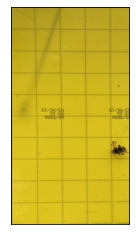

62

In [13]:
# code work flow
path = './org/7.jpg'
croped_img = sticky_card_crop(path)
img = padding_pic(croped_img)
kmeans_result = pest_count_by_kmeans_and_binarz(img)
Elliptical_Fit_result, ellipse_area = Elliptical_Fit(kmeans_result, croped_img)
len(ellipse_area)